# LB03: Задача регрессии с помощью решающих деревьев и линейных моделей

<div style="text-align: right"> ПСА 5 (Введение в машинное обучение). Мехмат, БГУ</div>
    
<div style="text-align: right"> Тишуров Алексей, 2021 </div>

Данный материал использует лицензию [Creative Commons CC BY-NC-SA 4.0.](https://creativecommons.org/licenses/by-nc-sa/4.0/) со всеми вытекающими. На прилагаемый к материалу датасет лицензия не распостраняется. 

В рамках данной лабораторной работы вы попробуете на практике решающие деревья в применении к задаче регрессии, а также сравните их с линейными моделями. Кроме того, вы попробуете на практике кросс-валидацию и некоторые способы перебора гиперпараметров моделей.

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PowerTransformer, StandardScaler, QuantileTransformer
from sklearn.linear_model import SGDRegressor, ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_predict, cross_val_score, \
    GridSearchCV, RandomizedSearchCV, train_test_split, KFold
from eli5.sklearn import explain_decision_tree, explain_linear_regressor_weights
import seaborn as sns

# Полезные ссылки по теме

1. Официальная документация sklearn http://scikit-learn.org/stable/index.html
2. Темы 3-4 курса по машинному обучению от ods.ai https://habr.com/company/ods/blog/322626/
3. Лекция по решающим деревьям от ВШЭ https://www.hse.ru/mirror/pubs/share/215285956
4. Неплохая статья по регуляризации https://craftappmobile.com/l1-vs-l2-regularization/
5. Все еще книжка Elements of Statistical Learning https://web.stanford.edu/~hastie/ElemStatLearn/
6. Все еще курс Learning from Data https://work.caltech.edu/telecourse.html
7. Что такое гистограмма https://ru.wikipedia.org/wiki/%D0%93%D0%B8%D1%81%D1%82%D0%BE%D0%B3%D1%80%D0%B0%D0%BC%D0%BC%D0%B0

# Часть 1. Датасет

В этот раз мы будем использовать датасет, где нужно предсказать цену поддержаной машины в Индии на основе информации о ней.

Столбцы в данных:
- Name: Детальное название машины (марка, модель и т.д.) (строковый)
- Year: Год выпуска (категориальный)
- Kilometers_Driven - пробег (вещественный)
- Fuel_Type - используемое топливо (категориальный)
- Transmission - тип коробки передач (бинарный)
- Owner_Type - какой по номеру текущий владелец (категориальный)
- Mileage - расход топлива в километрах на литр (вещественный, *но требует преобразования в вещественный*)
- Engine - объем двигателя (вещественный, *но требует преобразования в вещественный*)
- Power - лошадиные силы (вещественный, *но требует преобразования в вещественный*)
- Seats - число сидений (может рассматриваться как категориальный)
- New_Price - цена аналогичной новой машины (очень много пропусков) (вещественный, *но требует преобразования в вещественный*)
- Price - цена машины в лахках рупи (сотни тысяч). Целевая переменная (вещественный).

Обратите внимание, что есть небольшое количество очень дорогих машин. Может ли это быть проблемой? 

*Да, так как для модели это большой неравномерный разброс данных, и она будет плохо реагировать на эти самые "выбросы".*

In [2]:
train = pd.read_csv('train-data.csv', index_col=0)

In [3]:
train.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


# Задание 1.1 Ознакомление с датасетом

Сделайте с датасетом все то, что делали с прошлыми датасетами: посмотрите на признаки, определите типы, нарисуйте, найдите пропуски и т.д

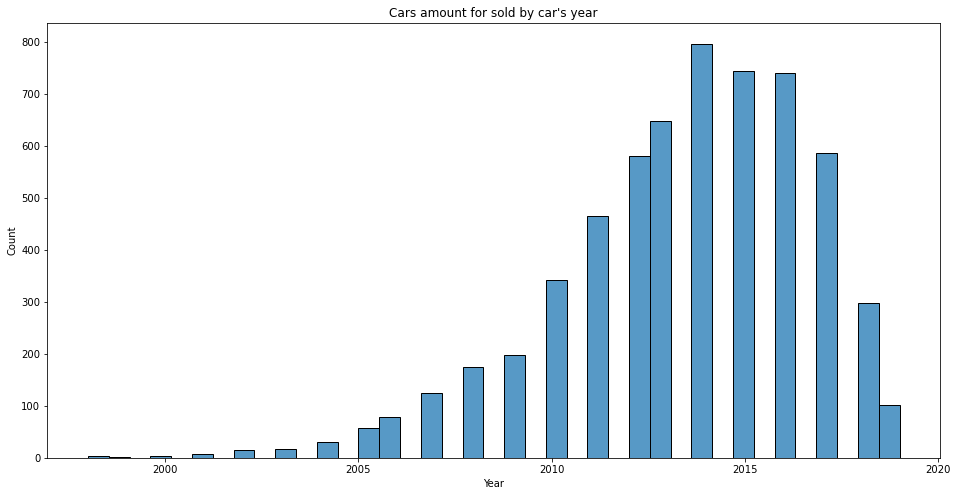

In [5]:
plt.figure(figsize=(16, 8))
plt.title('Cars amount for sold by car\'s year')
sns.histplot(train, x='Year')
plt.show()

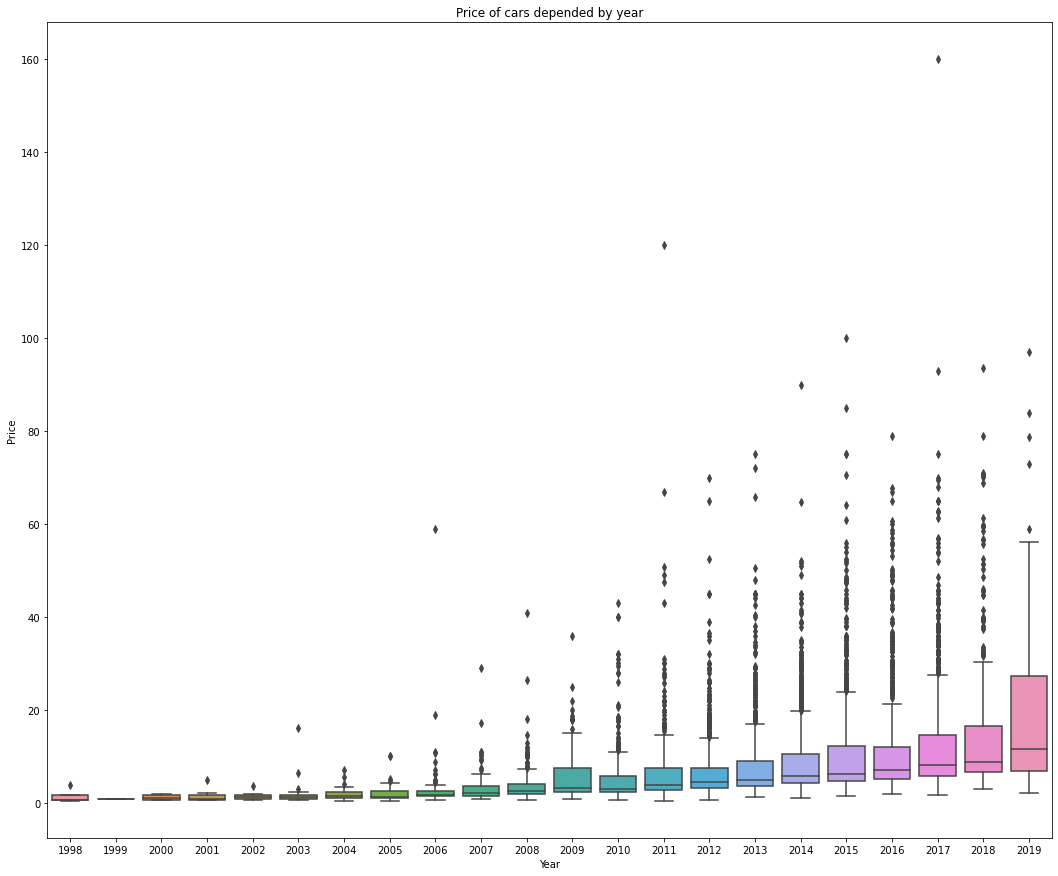

In [12]:
plt.figure(figsize=(18, 15))
plt.title('Price of cars depended by year')
plt.xlabel('Year')
plt.ylabel('Price')
sns.boxplot(x=train['Year'], y=train['Price'])
plt.show()

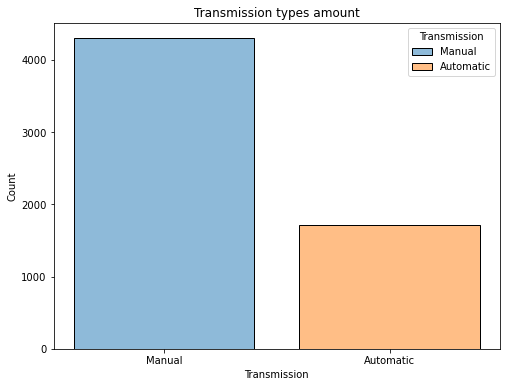

In [6]:
plt.figure(figsize=(8, 6))
plt.title('Transmission types amount')
sns.histplot(train, x='Transmission', hue='Transmission', shrink=0.8)
plt.show()

In [7]:
train.isnull().sum(axis=0)

Name                    0
Location                0
Year                    0
Kilometers_Driven       0
Fuel_Type               0
Transmission            0
Owner_Type              0
Mileage                 2
Engine                 36
Power                  36
Seats                  42
New_Price            5195
Price                   0
dtype: int64

In [8]:
train[train.isnull().sum(axis=1) > 0]

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74
5,Hyundai EON LPG Era Plus Option,Hyderabad,2012,75000,LPG,Manual,First,21.1 km/kg,814 CC,55.2 bhp,5.0,NaN,2.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6013,Honda Amaze VX i-DTEC,Coimbatore,2015,70602,Diesel,Manual,First,25.8 kmpl,1498 CC,98.6 bhp,5.0,NaN,4.83
6015,Hyundai Xcent 1.1 CRDi S,Jaipur,2015,100000,Diesel,Manual,First,24.4 kmpl,1120 CC,71 bhp,5.0,NaN,4.00
6016,Mahindra Xylo D4 BSIV,Jaipur,2012,55000,Diesel,Manual,Second,14.0 kmpl,2498 CC,112 bhp,8.0,NaN,2.90
6017,Maruti Wagon R VXI,Kolkata,2013,46000,Petrol,Manual,First,18.9 kmpl,998 CC,67.1 bhp,5.0,NaN,2.65


Как видно, в столбце New_Price очень много пропусков.

# Задание 1.2 Подготовка признаков

Над признаками этого датасета нужно поработать немного больше.

1. Преобразуйте числовые признаки (Mileage, Power, Engine, New_Price) так, чтобы они были реально числами. Т.е. удалите лишнее и преобразуется в float

2. Извлеките из имени машины как минимум марку в качестве отдельного признака. Если у вас есть идеи для других признаков на основе Name (и любых других вообще), то реализуйте их. Стоит ли использовать признак Name напрямую?

*Нет, но можно попробовать использовать его в качестве категориального признака, потому что есть автолюбители с конкретной любимой маркой машины.*

3. Превратите выбранные категориальные признаки в числовые с помощью pd.get_dummies или любого способа, который вам нравится

4. Что будем делать с New_Price?

*Заменим значения нулями пока что. Можно попробовать и учитывать, и не учитывать его при тренировке и сравнить полученные результаты.*

In [4]:
train['Mileage'] = train['Mileage'].apply(lambda x: str(x).split()[0])
train['Power'] = train['Power'].apply(lambda x: str(x).split()[0])
train['Engine'] = train['Engine'].apply(lambda x: str(x).split()[0])
train['New_Price'] = train['New_Price'].apply(lambda x: str(x).split()[0])

In [5]:
train.fillna(value=0, inplace=True)
train = train.replace('null', 0)

In [6]:
train['Mileage'] = train['Mileage'].apply(lambda x: np.nan_to_num(float(x)))
train['Power'] = train['Power'].apply(lambda x: np.nan_to_num(float(x)))
train['Engine'] = train['Engine'].apply(lambda x: np.nan_to_num(float(x)))
train['New_Price'] = train['New_Price'].apply(lambda x: np.nan_to_num(float(x)))

train['Year'] = train['Year'].astype(str)
train['Seats'] = train['Seats'].apply(lambda x: str(int(x)))

train['Transmission'] = train['Transmission'].apply(lambda x: 1 if x == 'Automatic' else 0)

In [7]:
train.loc[train.isnull().sum(axis=1) == True]

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price


In [8]:
auto_brand = train['Name'].apply(lambda x: x.split()[0])
train.insert(0, 'Brand', auto_brand)

In [9]:
categorical_cols = ['Brand', 'Name', 'Location', 'Fuel_Type', 'Owner_Type']

In [10]:
pd.get_dummies(train[categorical_cols])

,Brand_Ambassador,Brand_Audi,Brand_BMW,Brand_Bentley,Brand_Chevrolet,Brand_Datsun,Brand_Fiat,Brand_Force,Brand_Ford,Brand_Honda,...,Location_Pune,Fuel_Type_CNG,Fuel_Type_Diesel,Fuel_Type_Electric,Fuel_Type_LPG,Fuel_Type_Petrol,Owner_Type_First,Owner_Type_Fourth & Above,Owner_Type_Second,Owner_Type_Third
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6014,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
6015,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
6016,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
6017,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0


In [11]:
train_cat = pd.get_dummies(train[categorical_cols])
train = pd.concat([train.drop(categorical_cols, axis=1), 
                    train_cat], axis=1)

In [12]:
transmission = train['Transmission']
train.drop('Transmission', axis=1, inplace=True)
train.insert(8, 'Transmission', transmission)

In [13]:
train

,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,New_Price,Price,Transmission,Brand_Ambassador,...,Location_Pune,Fuel_Type_CNG,Fuel_Type_Diesel,Fuel_Type_Electric,Fuel_Type_LPG,Fuel_Type_Petrol,Owner_Type_First,Owner_Type_Fourth & Above,Owner_Type_Second,Owner_Type_Third
0,2010,72000,26.60,998.0,58.16,5,0.00,1.75,0,0,...,0,1,0,0,0,0,1,0,0,0
1,2015,41000,19.67,1582.0,126.20,5,0.00,12.50,0,0,...,1,0,1,0,0,0,1,0,0,0
2,2011,46000,18.20,1199.0,88.70,5,8.61,4.50,0,0,...,0,0,0,0,0,1,1,0,0,0
3,2012,87000,20.77,1248.0,88.76,7,0.00,6.00,0,0,...,0,0,1,0,0,0,1,0,0,0
4,2013,40670,15.20,1968.0,140.80,5,0.00,17.74,1,0,...,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6014,2014,27365,28.40,1248.0,74.00,5,7.88,4.75,0,0,...,0,0,1,0,0,0,1,0,0,0
6015,2015,100000,24.40,1120.0,71.00,5,0.00,4.00,0,0,...,0,0,1,0,0,0,1,0,0,0
6016,2012,55000,14.00,2498.0,112.00,8,0.00,2.90,0,0,...,0,0,1,0,0,0,0,0,1,0
6017,2013,46000,18.90,998.0,67.10,5,0.00,2.65,0,0,...,0,0,0,0,0,1,1,0,0,0


# Задание 1.3 Анализ целевой переменной



**Проанализируйте целевую переменную в этом датасете**. Является ли она смещенной (skewed)? Для ответа на этот вопрос нарисуйте гистограмму с удачным количеством бинов.

Если она смещена, то опробуйте на ней np.log1p и PowerTransformer. Нарисуйте гистограммы преобразованных целевых переменных. Сделайте выводы.

Подготовьте целевую переменную и отделите ее от признаков

In [14]:
pt = PowerTransformer()
pt_price = pt.fit_transform(train['Price'].to_numpy().reshape(-1, 1))

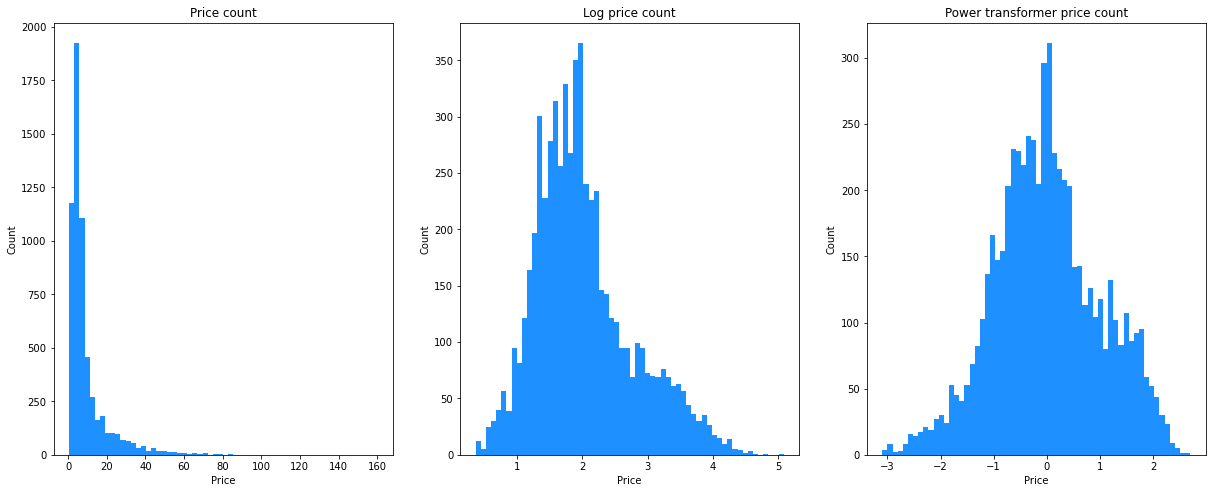

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8, 6))
plt.subplots_adjust(1, 2, 3, 3)
ax[0].set_title('Price count')
ax[0].set_xlabel('Price')
ax[0].set_ylabel('Count')
ax[0].hist(train['Price'], bins=60, color='dodgerblue')

ax[1].set_title('Log price count')
ax[1].set_xlabel('Price')
ax[1].set_ylabel('Count')
ax[1].hist(np.log1p(train['Price']), bins=60, color='dodgerblue')

ax[2].set_title('Power transformer price count')
ax[2].set_xlabel('Price')
ax[2].set_ylabel('Count')
ax[2].hist(pt_price, bins=60, color='dodgerblue')
plt.show()

*Смещение по сути - это степень искажения нормального распределения.*

*В данном случае мы видим, что большинство цен в наших данных варьируется в диапазоне от 0 до 20. Это не очень хорошо для обучения модели, так как важность некоторых признаков при обучении может быть искажена и модель не будет способна предсказывать бОльшие цены, так как данных для таких цен не хватает.*

*При логарифмическом преобразовании, разброс целевой переменной стал более симметричным, однако не до конца (есть небольшое смещение влево);*

*Power transform в свою очередь делает распределение более похожим на нормальное. С точки зрения статистики, это преобразование стабилизирует дисперсию распределения. Как видно на гистограмме выше, распределение целевой переменной стало еще более симметричным.*

In [16]:
y = train['Price']
train = train.drop(['Price'], axis=1)

In [17]:
train

,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,New_Price,Transmission,Brand_Ambassador,Brand_Audi,...,Location_Pune,Fuel_Type_CNG,Fuel_Type_Diesel,Fuel_Type_Electric,Fuel_Type_LPG,Fuel_Type_Petrol,Owner_Type_First,Owner_Type_Fourth & Above,Owner_Type_Second,Owner_Type_Third
0,2010,72000,26.60,998.0,58.16,5,0.00,0,0,0,...,0,1,0,0,0,0,1,0,0,0
1,2015,41000,19.67,1582.0,126.20,5,0.00,0,0,0,...,1,0,1,0,0,0,1,0,0,0
2,2011,46000,18.20,1199.0,88.70,5,8.61,0,0,0,...,0,0,0,0,0,1,1,0,0,0
3,2012,87000,20.77,1248.0,88.76,7,0.00,0,0,0,...,0,0,1,0,0,0,1,0,0,0
4,2013,40670,15.20,1968.0,140.80,5,0.00,1,0,1,...,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6014,2014,27365,28.40,1248.0,74.00,5,7.88,0,0,0,...,0,0,1,0,0,0,1,0,0,0
6015,2015,100000,24.40,1120.0,71.00,5,0.00,0,0,0,...,0,0,1,0,0,0,1,0,0,0
6016,2012,55000,14.00,2498.0,112.00,8,0.00,0,0,0,...,0,0,1,0,0,0,0,0,1,0
6017,2013,46000,18.90,998.0,67.10,5,0.00,0,0,0,...,0,0,0,0,0,1,1,0,0,0


# Часть 2. Регрессия с помощью решающих деревьев

# Задание 2.1 Обучение решающих деревьев и кросс-валидация

ВНИМАНИЕ! В этот раз мы больше не разделяем данные с помощью train_test_split, а используем cross_val_score или cross_val_predict. Примеры использования тут https://scikit-learn.org/stable/modules/cross_validation.html#computing-cross-validated-metrics. Вам нужно явно указать mse в качестве метрики, если используете score и явно вычислять mean_squared_error в случае predict.

Проведите над этими данными следующие операции (не забывайте ВЕЗДЕ фиксировать random_state для воспроизводимости экспериментов. Без этого оценка за лабу **будет гореть**):
1. Обучить решающее дерево без каких либо ограничений
2. Обучить решающее дерево с ограничением глубины. Перебрать глубину от 2 до 10 и нарисовать график изменения MSE в зависимости от глубины. Выбрать лучшую глубину
3. Обучить решающее дерево с зафиксированным ограничением глубины с прошлого пункта и изменением минимального числа примеров для разделения от 2 до 150 с шагом 5. Построить аналогичный график и выбрать лучшее значение

В каждом эксперименте вам нужно использовать cross_val_score/cross_val_predict с выбранным выше методом разбиения на фолды, чтобы измерить mean_squared_error. В качестве финального скора используйте среднее значение по всем фолдам. Также для каждого эксперимента оцените дисперсию оценки и сделайте выводы.

Наконец, подумайте, есть ли еще параметры, значения которых стоит перебирать в этой задаче? Если ответ - да, то проведите соответствующие эксперименты.


## Дерево без ограничений

In [18]:
scaler = StandardScaler()
real_features = scaler.fit_transform(train.iloc[:, :7])
rest_features = train.iloc[:, 7:].to_numpy()

In [19]:
X = np.hstack([real_features, rest_features])

In [20]:
reg = DecisionTreeRegressor(random_state=0, criterion='mse')
cv = KFold(n_splits=5, shuffle=True, random_state=42)

### Значение MSE по 5 фолдам на кросс-валидации

In [26]:
score = -cross_val_score(reg, X, y, cv=cv, scoring='neg_mean_squared_error')
print('MSE score: {} +- {}'.format(np.mean(score), np.std(score)))

MSE score: 21.486702274332167 +- 5.2831854689999895


## Деревья с ограничениями по глубине

In [27]:
mean_errors = []
std_errors = []
cv = KFold(n_splits=5, shuffle=True, random_state=42)

for depth in range(2, 11):
    reg = DecisionTreeRegressor(random_state=0, max_depth=depth, criterion='mse')

    score = -cross_val_score(reg, X, y, cv=cv, scoring='neg_mean_squared_error')
    
    mean_errors.append(np.mean(score))
    std_errors.append(np.std(score))

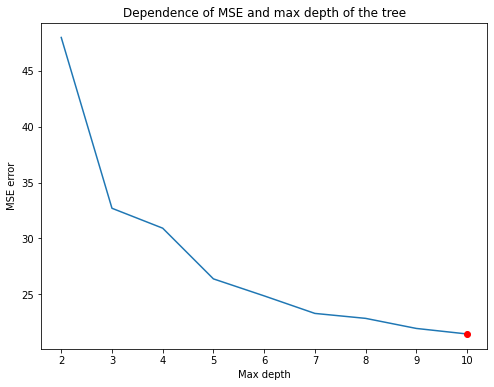

In [28]:
x = np.arange(2, 11)
plt.figure(figsize=(8, 6))
plt.title('Dependence of MSE and max depth of the tree')
plt.xlabel('Max depth')
plt.ylabel('MSE error')
plt.plot(x, mean_errors)
plt.plot(np.argmin(mean_errors) + 2, np.min(mean_errors), 'o', color='red')
plt.show()

### Средние значение и дисперсия MSE в зависимости от максимальной глубины дерева 

In [29]:
print('\n'.join([f'MSE for depth {idx + 2}: {mean} +- {std}' 
    for idx, (mean, std) in enumerate(zip(mean_errors, std_errors))]))

MSE for depth 2: 47.96299237208561 +- 7.804286047798807
MSE for depth 3: 32.700979569678296 +- 6.807715377433279
MSE for depth 4: 30.92183653426041 +- 6.4581332865170324
MSE for depth 5: 26.391775028239728 +- 5.660611850753115
MSE for depth 6: 24.87285461458153 +- 5.557869575128926
MSE for depth 7: 23.30600560724658 +- 5.94244186290757
MSE for depth 8: 22.86331863641144 +- 5.265888326781361
MSE for depth 9: 21.963142898683905 +- 4.868108980665262
MSE for depth 10: 21.468769370955194 +- 5.6947283737240735


In [30]:
np.argmin(mean_errors) + 2, np.min(mean_errors)

(10, 21.468769370955194)

## Деревья с ограничениями по минимальному числу подвыборки

In [31]:
mean_errors = []
std_errors = []
cv = KFold(n_splits=5, shuffle=True, random_state=42)

for min_samples_split in range(2, 151, 5):
    reg = DecisionTreeRegressor(random_state=0, max_depth=10, 
                                min_samples_split=min_samples_split, criterion='mse')

    score = -cross_val_score(reg, X, y, cv=cv, scoring='neg_mean_squared_error')
    
    mean_errors.append(np.mean(score))
    std_errors.append(np.std(score))

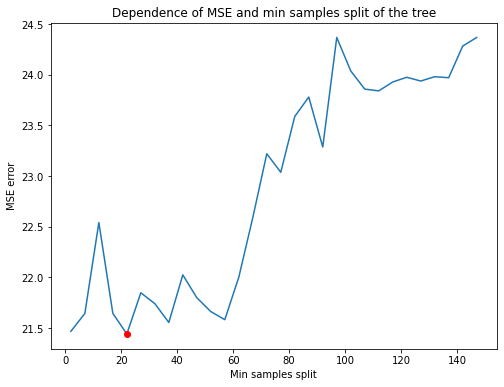

In [32]:
x = np.arange(2, 151, 5)
plt.figure(figsize=(8, 6))
plt.title('Dependence of MSE and min samples split of the tree')
plt.xlabel('Min samples split')
plt.ylabel('MSE error')
plt.plot(x, mean_errors)
plt.plot(5*np.argmin(mean_errors) + 2, np.min(mean_errors), 'o', color='red')
plt.show()

### Средние значение и дисперсия MSE в зависимости от минимального числа подвыборки

In [33]:
print('\n'.join([f'MSE for depth {5*idx + 2}: {mean} +- {std}' 
    for idx, (mean, std) in enumerate(zip(mean_errors, std_errors))]))

MSE for depth 2: 21.468769370955194 +- 5.6947283737240735
MSE for depth 7: 21.644931709436495 +- 4.836871893204219
MSE for depth 12: 22.54167883434434 +- 5.310533247312297
MSE for depth 17: 21.64558793297184 +- 5.052356099513819
MSE for depth 22: 21.442544980722502 +- 4.6293617859922795
MSE for depth 27: 21.848783550502812 +- 4.666933006013245
MSE for depth 32: 21.741705604773436 +- 4.416663026929434
MSE for depth 37: 21.5559660262656 +- 4.225335289993584
MSE for depth 42: 22.02535374389467 +- 4.078702668165697
MSE for depth 47: 21.800024309202627 +- 3.972972621143566
MSE for depth 52: 21.663529821113677 +- 4.36683574210939
MSE for depth 57: 21.58363103510526 +- 4.247450703400535
MSE for depth 62: 22.00235745865498 +- 4.218435809252659
MSE for depth 67: 22.590132984116913 +- 5.0199829777166665
MSE for depth 72: 23.219899777999036 +- 5.014873928262266
MSE for depth 77: 23.037540270913304 +- 5.051719030681578
MSE for depth 82: 23.588225161486264 +- 5.2429786298081416
MSE for depth 87: 23

In [34]:
5*np.argmin(mean_errors) + 2, np.min(mean_errors)

(22, 21.442544980722502)

# Задание 2.2 Визуализация решающих деревев

Дополнительно ознакомьтесь с возможностью визуализации решающих деревьев и объяснении их работы

Обучите дерево без использования Location и признаков на основе Name (иначе будет очень громоздко), с ограничением глубины 5-6 и нарисуйте его с помощью библиотеки eli5.

Для отрисовки используйте функцию explain_decision_tree. Будьте готовы устно описать то, что происходит на полученной картинке. Если ваше лучшее дерево получилось слишком большим, то ограничьте его глубину до 4, чтобы на рисунок было удобно рассматривать.

Для установки используйте команду **conda install -y -c conda-forge eli5** или установите ее через графический интерфейс.


In [21]:
location_indices = np.where(train.columns.str.startswith('Location'))[0]
names_indices = np.where(train.columns.str.startswith('Name'))[0]
brand_indices = np.where(train.columns.str.startswith('Brand'))[0]

features_indices_to_drop = np.concatenate([brand_indices, names_indices, location_indices])
features_to_drop = train.iloc[:, features_indices_to_drop].columns

In [22]:
X = train.drop(features_to_drop, axis=1)

In [23]:
X

,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,New_Price,Transmission,Fuel_Type_CNG,Fuel_Type_Diesel,Fuel_Type_Electric,Fuel_Type_LPG,Fuel_Type_Petrol,Owner_Type_First,Owner_Type_Fourth & Above,Owner_Type_Second,Owner_Type_Third
0,2010,72000,26.60,998.0,58.16,5,0.00,0,1,0,0,0,0,1,0,0,0
1,2015,41000,19.67,1582.0,126.20,5,0.00,0,0,1,0,0,0,1,0,0,0
2,2011,46000,18.20,1199.0,88.70,5,8.61,0,0,0,0,0,1,1,0,0,0
3,2012,87000,20.77,1248.0,88.76,7,0.00,0,0,1,0,0,0,1,0,0,0
4,2013,40670,15.20,1968.0,140.80,5,0.00,1,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6014,2014,27365,28.40,1248.0,74.00,5,7.88,0,0,1,0,0,0,1,0,0,0
6015,2015,100000,24.40,1120.0,71.00,5,0.00,0,0,1,0,0,0,1,0,0,0
6016,2012,55000,14.00,2498.0,112.00,8,0.00,0,0,1,0,0,0,0,0,1,0
6017,2013,46000,18.90,998.0,67.10,5,0.00,0,0,0,0,0,1,1,0,0,0


In [38]:
reg = DecisionTreeRegressor(criterion='mse', max_depth=4, random_state=0)
reg.fit(X, y)

DecisionTreeRegressor(max_depth=4, random_state=0)

In [39]:
explain_decision_tree(reg, feature_names=list(X.columns))

Weight,Feature
0.7562,Power
0.1504,Year
0.0530,Kilometers_Driven
0.0363,Engine
0.0041,Transmission
0,Mileage
0,Seats
0,New_Price
0,Owner_Type_Third
0,Owner_Type_Second


# Часть 3. Регрессия с помощью линейных моделей

В этом разделе вам предстоит поработать с линейной регрессией, поиграть с регуляризацией, градиентным спуском и функционалами потерь. Используем тот же датасет, что и выше.

Дополнительно в этом разделе необходимо ознакомиться с GridSearchCV, чтобы перебирать параметры не независимо, а вместе. Совместный перебор разных гиперпараметров необходим в реальных задачах, так как параметры влияют друг на друга, а независимый перебор как в задании выше может привести к выбору неоптимальной конфигурации.

# Часть 3.1 Перебор гиперпараметров

Вот так базово должен выглядеть набор параметров для перебора. Это словарь где ключ - название параметра, а значение - список из параметров для перебора Обратите внимание, что общее число операций будет равно произведению длин всех списков параметров. Так что будьте аккуратны и не делайте их слишком много.

В качестве модели используйте либо ElasticNet (проще), либо SGDRegressor(сложнее) на ваш выбор.

Список ниже указан только для примера. Один из параметров перебирать бессмысленно, так как он не влияет на модель. Поэтому:
1. Найдите его и удалите
2. Добавите параметры, которые важны для настройки, расширьте диапазон уже включенных параметров, если нужно. Будьте готовы объяснить ваш выбор.
3. Проведите поиск по сетке(возможно, придется сходить попить чай, пока будет вычисляться), обучите модель с лучшими параметрам и сравните ее качество с лучшим решающим дерево из предыдущего задания
4. **Hint**: Вполне возможно, что huber loss в данной задаче хороший выбор. Не забудьте проверить и его тоже


**Не забывайте стандартизировать признаки перед обучением!!**

Обучите модель с лучшими предсказаниями и сделайте cross_val_predict. Постройте распределение предсказаний и целевой переменной. Сравните. Вычислите среднюю абсолютную и среднюю квадратичную ошибку модели.

Объясните вашу модель при помощи библиотеки eli5 (explain_linear_regressor_weights)

In [24]:
X = np.hstack([real_features, rest_features])

### ElasticNet

In [41]:
grid1 = {
        'alpha': [0, 0.2, 0.5, 1],
        'l1_ratio': [0, 0.5, 1.0],
        'selection': ['cyclic', 'random']
    }

In [42]:
search = GridSearchCV(ElasticNet(random_state=33, max_iter=2000), param_grid=grid1, return_train_score=True,
                      cv=KFold(5, shuffle=True, random_state=33), verbose=1,
                      scoring='neg_mean_absolute_error', n_jobs=-1)

In [43]:
search.fit(X, y)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:880: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.best_estimator_.fit(X, y, **fit_params)
C:\Users\Dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\Dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13327.844288254762, tolerance: 75.32699866987208
  positive)


GridSearchCV(cv=KFold(n_splits=5, random_state=33, shuffle=True),
             estimator=ElasticNet(max_iter=2000, random_state=33), n_jobs=-1,
             param_grid={'alpha': [0, 0.2, 0.5, 1], 'l1_ratio': [0, 0.5, 1.0],
                         'selection': ['cyclic', 'random']},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [44]:
search.best_estimator_

ElasticNet(alpha=0, l1_ratio=0, max_iter=2000, random_state=33,
           selection='random')

In [25]:
elastic_model = ElasticNet(alpha=0, l1_ratio=0, random_state=33, 
                            max_iter=1000)

In [26]:
pred_1 = cross_val_predict(elastic_model, X, y, cv=cv)

C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:946: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\Dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9006.173906522221, tolerance: 60.50865602753067
  positive)
C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:946: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Dell\anac

In [27]:
print(f'MSE: {1/len(y) * np.sum((y - pred_1)**2)} \n' +
        f'MAE: {1/len(y) * np.sum(np.abs(y - pred_1))}')

MSE: 25.98645367065276 
MAE: 2.3891795683105075


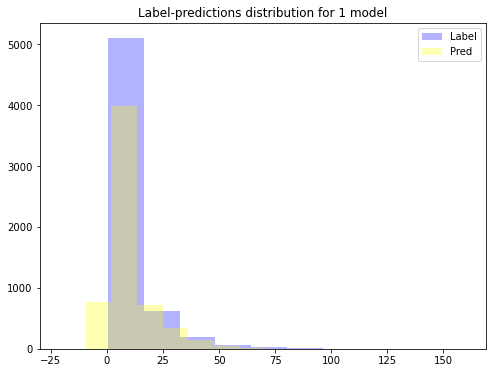

In [34]:
plt.figure(figsize=(8, 6))
plt.title('Label-predictions distribution for 1 model')
plt.hist(y, color='blue', alpha=0.3)
plt.hist(pred_1, color='yellow', alpha=0.3)
plt.legend(['Label', 'Pred'])
plt.show()

### SGDRegressor

In [49]:
grid2 = {
        'penalty': ['l1', 'l2', 'elasticnet'],
        'alpha': [1e-4, 1e-5, 5e-4, 5e-5],
        'l1_ratio': [0.1, 0.2, 0.3, 0.5],
        'learning_rate': ['constant', 'optimal', 'adaptive'],
        'loss': ['squared_loss', 'huber', 'epsilon_insensitive','squared_epsilon_insensitive']
    }

In [50]:
greg = GridSearchCV(SGDRegressor(random_state=33), param_grid=grid2, return_train_score=True,
                      cv=KFold(5, shuffle=True, random_state=33), verbose=1,
                      scoring='neg_mean_squared_error', n_jobs=-1)

In [51]:
greg.fit(X, y)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=33, shuffle=True),
             estimator=SGDRegressor(random_state=33), n_jobs=-1,
             param_grid={'alpha': [0.0001, 1e-05, 0.0005, 5e-05],
                         'l1_ratio': [0.1, 0.2, 0.3, 0.5],
                         'learning_rate': ['constant', 'optimal', 'adaptive'],
                         'loss': ['squared_loss', 'huber',
                                  'epsilon_insensitive',
                                  'squared_epsilon_insensitive'],
                         'penalty': ['l1', 'l2', 'elasticnet']},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

In [52]:
greg.best_estimator_

SGDRegressor(alpha=5e-05, l1_ratio=0.1, learning_rate='optimal',
             loss='epsilon_insensitive', penalty='l1', random_state=33)

In [46]:
sgd_reg_model = SGDRegressor(alpha=5e-5, l1_ratio=0.1, learning_rate='optimal', penalty='l1',
                        loss='epsilon_insensitive', random_state=33)

In [47]:
pred_2 = cross_val_predict(sgd_reg_model, X, y, cv=cv)

In [48]:
print(f'MSE: {1/len(y) * np.sum((y - pred_2)**2)} \n' +
        f'MAE: {1/len(y) * np.sum(np.abs(y - pred_2))}')

MSE: 21.81046785255788 
MAE: 1.9275058766976507


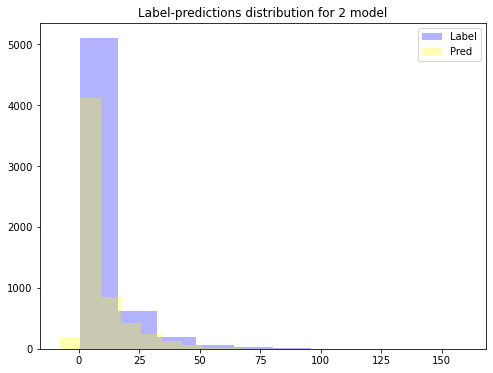

In [63]:
plt.figure(figsize=(8, 6))
plt.title('Label-predictions distribution for 2 model')
plt.hist(y, color='blue', alpha=0.3)
plt.hist(pred_2, color='yellow', alpha=0.3)
plt.legend(['Label', 'Pred'])
plt.show()

In [77]:
explain_linear_regressor_weights(search.best_estimator_, feature_names=list(train.columns))

Weight?,Feature
+132.445,Name_Land Rover Range Rover 3.0 Diesel LWB Vogue
+83.010,Name_Lamborghini Gallardo Coupe
+62.840,Name_BMW 7 Series 740Li
+62.546,Name_Jaguar F Type 5.0 V8 S
+59.768,Name_Mercedes-Benz SLK-Class 55 AMG
+58.613,Name_Mercedes-Benz E-Class E 350 d
+57.564,Name_Mercedes-Benz GLS 350d Grand Edition
+55.535,Name_Land Rover Range Rover Sport SE
+53.095,Name_Audi Q7 45 TDI Quattro Premium Plus
+50.759,Name_BMW X6 xDrive 40d M Sport


In [78]:
explain_linear_regressor_weights(greg.best_estimator_, feature_names=list(train.columns))

Weight?,Feature
+29.846,Name_BMW 7 Series 740Li
+28.187,Name_Audi Q7 45 TDI Quattro Technology
+26.599,Name_BMW X5 xDrive 30d M Sport
+24.917,Brand_Porsche
+24.735,Name_Land Rover Range Rover Sport SE
+24.598,Name_Mercedes-Benz E-Class 2015-2017 E350 CDI Avantgrade
+23.246,Name_BMW X6 xDrive 40d M Sport
+21.710,Name_BMW X5 X5 M
+21.600,Name_Mercedes-Benz GLE 250d
+21.312,Name_Mercedes-Benz GLE 350d


# Часть 3.2 Ограничение предсказаний линейной регрессии 

Мы обсуждали на лекции, что линейные модели без тормозов. Они не могут ограничивать диапазон своих предсказаний. В этом задании вам может быть нужно быстро им помочь, ограничив их после предсказания, что в теории может привести к улучшению общего качества.

Нужно сделать следующее:
- Определить, есть ли такая проблема в датасете, т.е. есть ли отрицательные предсказания или слишком большие.  Если такого нет, то переходите дальше (это в теории может зависеть от ваших решений во время выполнения работы).
- Взять лучшую моделю, полученную на поиске, применить cross_val_predict (вместо cross_val_score) и использовать np.clip перед подачей предсказаний в метрику, сравнить со значениями без клиппинга и сделать выводы.

In [30]:
def MSE(y, y_pred):
    return 1/len(y) * np.sum((y - y_pred)**2)

In [80]:
sgd_reg_model = SGDRegressor(alpha=5e-5, l1_ratio=0.1, learning_rate='optimal', penalty='l1',
                        loss='epsilon_insensitive', random_state=33)

### С клиппингом

In [83]:
y_pred_clipped = np.clip(cross_val_predict(sgd_reg_model, X, y, cv=5), 0, 75)
MSE(y, y_pred_clipped)

22.44985560472769

### Без клиппинга

In [84]:
y_pred_without_clip = cross_val_predict(sgd_reg_model, X, y, cv=5)
MSE(y, y_pred_without_clip)

23.057812784598745

Они не сильно отличаются.

# Часть 3.3 * (На 10) Еще помогаем линейной регрессии соревноваться

Ничто не гарантирует, что перебор параметров выбрал бы именно эти, если бы np.clip проходил прямо внутри модели во время перебора. Чтобы наверняка выбрать лучшую модель, переопределите класс ElasticNet (или SGDRegressor) так, чтобы сразу после предикта предсказания за пределами диапазона датасета заменялись на минимум и максимум соответственно и проведите новый поиск по сетке.

Я уверен, что если до этого задания кто и доберется, то он наверняка без проблем сможет разобраться, как это реализовать. Если же вдруг будут вопросы, то пусть этот неизвестный пока герой напишет мне и задаст их.

# Часть 3.4. Преобразования целевой переменной

В этом задании вам необходимо сравнить качество работы линейной регрессии без и с преобразованием целевой переменной на основе наработок из задания 1.3

Для этого нужно взять PowerTransformer и преобразовать целевую переменную. А затем провести grid search снова. Лучшая модель в этом случае будет предсказывать преобразованную целевую переменную. Вернуться к изначальной необходимо, применив к предсказаниям inverse_transform у обученного объекта PowerTransformer.

**ВНИМАНИЕ**!! Без обратного преобразования результаты моделей несравнимы.


В конце концов, постройте гистограмму предсказаний в случаях с преобразованием и без него. Сравните с гистограммой целевой переменной. В каком случае распределение предсказаний выглядит наиболее похожим на настоящее?

In [38]:
y_trans = pt_price.flatten()

In [35]:
grid0 = {
        'penalty': ['l1', 'l2', 'elasticnet'],
        'alpha': [1e-4, 1e-5, 5e-5],
        'l1_ratio': [0.1, 0.3, 0.5],
        'learning_rate': ['optimal', 'adaptive'],
        'loss': ['huber', 'epsilon_insensitive']
    }

In [36]:
greg0 = GridSearchCV(SGDRegressor(random_state=33), param_grid=grid0, return_train_score=True,
                      cv=KFold(5, shuffle=True, random_state=33), verbose=1,
                      scoring='neg_mean_squared_error', n_jobs=-1)

In [37]:
greg0.fit(X, y_trans)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=33, shuffle=True),
             estimator=SGDRegressor(random_state=33), n_jobs=-1,
             param_grid={'alpha': [0.0001, 1e-05, 5e-05],
                         'l1_ratio': [0.1, 0.3, 0.5],
                         'learning_rate': ['optimal', 'adaptive'],
                         'loss': ['huber', 'epsilon_insensitive'],
                         'penalty': ['l1', 'l2', 'elasticnet']},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

In [38]:
greg0.best_estimator_

SGDRegressor(alpha=1e-05, l1_ratio=0.3, learning_rate='adaptive',
             loss='epsilon_insensitive', penalty='elasticnet', random_state=33)

In [39]:
reg0 = SGDRegressor(alpha=1e-5, l1_ratio=0.3, learning_rate='adaptive', penalty='elasticnet',
                        loss='epsilon_insensitive', random_state=33)

In [40]:
pred_0 = cross_val_predict(reg0, X, y_trans, cv=cv)
y_pred = pt.inverse_transform(pred_0.reshape(-1, 1)).flatten()

In [56]:
print(f'MSE: {1/len(y) * np.sum((y - y_pred)**2)} \n' +
        f'MAE: {1/len(y) * np.sum(np.abs(y - y_pred))}')

MSE: 127.37611971973031 
MAE: 1.9708026935248961


In [59]:
np.max(np.abs(y - y_pred))

597.918946377694

*Как можно видеть, в предсказании есть выброс. В принципе большой MSE и маленький MAE на это указывают.*

*Еще возник момент, который мне не до конца ясен...*

*Если тренировать модель с нормализованной целевой переменной, график распределения получается адекватный (если и он тоже строится относительно нормализованных предсказаний). Но если модель обучена с ненормализованной целевой переменной y, то, применив к предсказаниям pt.transform(), получаем разные распределения, что мне показалось достаточно странным.*

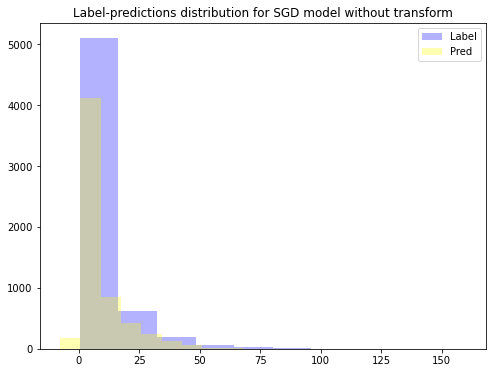

In [60]:
plt.figure(figsize=(8, 6))
plt.title('Label-predictions distribution for SGD model without transform')
plt.hist(y, color='blue', alpha=0.3)
plt.hist(pred_2, color='yellow', alpha=0.3)
plt.legend(['Label', 'Pred'])
plt.show()

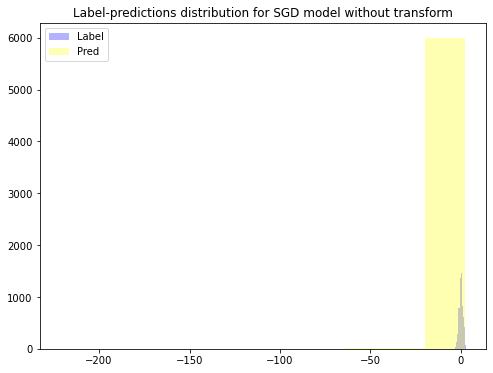

In [52]:
plt.figure(figsize=(8, 6))
plt.title('Label-predictions distribution for SGD model without transform')
plt.hist(y_trans, color='blue', alpha=0.3)
plt.hist(pt.transform(pred_2.reshape(-1, 1)), color='yellow', alpha=0.3)
plt.legend(['Label', 'Pred'])
plt.show()

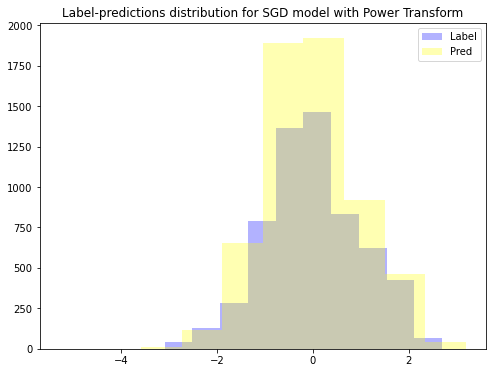

In [54]:
plt.figure(figsize=(8, 6))
plt.title('Label-predictions distribution for SGD model with Power Transform')
plt.hist(y_trans, color='blue', alpha=0.3)
plt.hist(pt.transform(y_pred.reshape(-1, 1)), color='yellow', alpha=0.3)
plt.legend(['Label', 'Pred'])
plt.show()

# Часть 3.5. Полноценный подбор гиперпараметров для решающего дерева

Название говорит само за себя. Проведите процедуру поиска по сетке важный параметров для дерева на этой же задаче. Объясните выбор своих параметров и будьте готовы отвечать на вопросы о их значении. В качестве способа поисков можете выбирать любой

In [62]:
params = {
    'criterion': ['mse', 'friedman_mse', 'mae', 'poisson'],
    'splitter': ['best', 'random'],
    'max_depth': np.arange(2, 10),
    'min_samples_split': np.arange(2, 151, 5)
}

In [65]:
grid_reg = GridSearchCV(DecisionTreeRegressor(max_features=1/3, random_state=33), 
                        param_grid=params, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)

In [66]:
grid_reg.fit(X, y)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=DecisionTreeRegressor(max_features=0.3333333333333333,
                                             random_state=33),
             n_jobs=-1,
             param_grid={'criterion': ['mse', 'friedman_mse', 'mae', 'poisson'],
                         'max_depth': array([2, 3, 4, 5, 6, 7, 8, 9]),
                         'min_samples_split': array([  2,   7,  12,  17,  22,  27,  32,  37,  42,  47,  52,  57,  62,
        67,  72,  77,  82,  87,  92,  97, 102, 107, 112, 117, 122, 127,
       132, 137, 142, 147]),
                         'splitter': ['best', 'random']},
             scoring='neg_mean_squared_error')

In [67]:
grid_reg.best_estimator_

DecisionTreeRegressor(criterion='mae', max_depth=9,
                      max_features=0.3333333333333333, min_samples_split=12,
                      random_state=33)

In [68]:
reg_tree = DecisionTreeRegressor(criterion='mae', max_depth=9, max_features=1/3, 
                                min_samples_split=12, random_state=33)

In [72]:
tree_pred = cross_val_predict(reg_tree, X, y, cv=cv)

In [73]:
print(f'MSE: {1/len(y) * np.sum((y - tree_pred)**2)} \n' +
        f'MAE: {1/len(y) * np.sum(np.abs(y - tree_pred))}')

MSE: 22.95689043030404 
MAE: 2.217240405382954


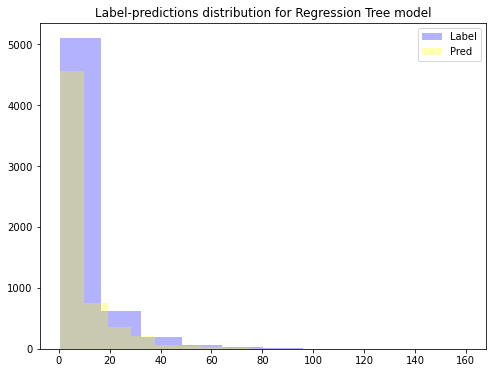

In [76]:
plt.figure(figsize=(8, 6))
plt.title('Label-predictions distribution for Regression Tree model')
plt.hist(y, color='blue', alpha=0.3)
plt.hist(tree_pred, color='yellow', alpha=0.3)
plt.legend(['Label', 'Pred'])
plt.show()

# Часть 3.6* (На 10). Первые шаги в смешивании моделей

По результатам работы выше у вас получилось 2 модели разной природы. Известно, что смешивание разных моделей улучшает качество работы, так как они предсказывают **по-разному**.
Самый простой способ смешивания - усреднение предсказаний с весами. Ваша задача - сделать такое усреднение и подобрать лучшие веса. Важно, чтобы для двух моделей использовалась **ИДЕНТИЧНАЯ** схема разбиения на фолды.

# Часть 3.7 (Необязательно, для любознательных). Другие варианты перебора гиперпараметров 

Попробуйте заменить GridSearchCV на RandomizedSearchCV и/или Halving{Grid/Randomized}SearchCV и поискать гиперпараметры еще. Сравните время на поиск и результаты. 

P.S. А в другой раз мы познакомимся с вами (энтузиастами) с подбором гиперпараметров с помощью байесовской оптимизации

# Часть 4. Возможность исправить проблемы с лабами и получить автомат

Отдельное задание для того, чтобы поправить среднюю оценку для получения автомата. К лабе оно не относится. Этим же заданием хорошим и ленивым студентам  дается возможность исправить возможные проблемы. Если его выполнить и защитить, то можно получить дополнительную десятку, которая, очевидно, хорошо повлияет на оценку. Выполнять можно до последней практики в семестре.

У вас есть два варианта на выбор:
1. Реализовать линейную регрессию с регуляризацией в общем виде(ElasticNet), которая обучается с помощью стохастического градиентного спуска
2. Реализовать решающие дерево вместе с обучением. Конкретный вариант дерева остается на ваш выбор(например, CART). Работаем только с классификацией и в качестве критерия рассматриваем индекс Джини или энтропийный критерий.

Линейную регрессию обучать на датасете из этой лабы, а решающее дерево на датасете из прошлой.

P.S. Два варианта выполнять точно не нужно, за это никаких дополнительных плюшек не будет. Пожалейте себя.


Самое главное: код должен быть написан и защищен вами. Сдать слегка измененный код из интернета не получится.